In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import btk

## Utility

In [ ]:
def get_psf_size(survey: btk.survey.Survey):
    psf_size_arcsec =  survey.get_filter('r').psf_fwhm.to_value('arcsec')
    pixel_scale = survey.pixel_scale.to_value('arcsec')
    return psf_size_arcsec / pixel_scale

## Setup simulation

In [ ]:
max_n_sources = 10
min_n_sources = 0
stamp_size = 24.0
max_shift = 3.0 # shift from center is 3 arcsecs = 15 pixels, so blends are likely.
seed = 0

catalog = btk.catalog.CatsimCatalog.from_file('../data/input_catalog.fits')

sampling_function = btk.sampling_functions.DefaultSampling(
    max_number=max_n_sources,
    min_number=min_n_sources,
    stamp_size=stamp_size, 
    max_shift=max_shift, 
    min_mag = 18, 
    max_mag = 27,
    seed = seed)

survey = btk.survey.get_surveys('LSST')

batch_size = 100

draw_generator = btk.draw_blends.CatsimGenerator(
    catalog,
    sampling_function,
    survey,
    batch_size=batch_size,
    stamp_size=stamp_size,
    njobs=1,
    add_noise="background",
    seed=seed, # use same seed here
)

## Example blends

In [ ]:
blend_batch = next(draw_generator)

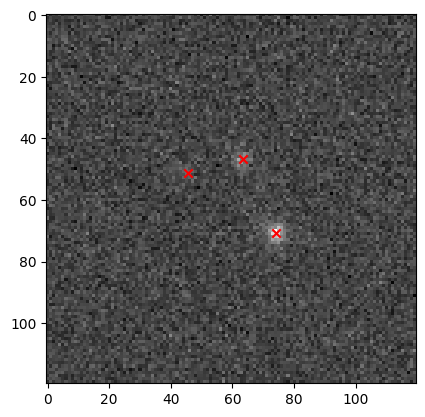

In [ ]:
import matplotlib.pyplot as plt

ii = np.random.randint(0, 100)

# plot the first blend in the batch, with the r-band
plt.imshow(blend_batch.blend_images[ii, 2, :, :], cmap="gray")

# plot centers
plt.scatter(blend_batch.catalog_list[ii]["x_peak"], 
            blend_batch.catalog_list[ii]["y_peak"], c="r", marker="x")

## Efficiency matrices using Peak-finding and SEP 

We will plot efficiency matrices comparing the peak-finding algorithm in `sklearn` and compare it with `SEP` (source extractor in python). We will run both algorithms on the `r`-band images.

We will accumulate the results over `1000` blends. 

In [ ]:
from btk.deblend import SepSingleBand, PeakLocalMax

# use psf size as minimum distance between peaks (in pixels).
min_distance = int(get_psf_size(survey)) # needs to be an integer

thresh = 1.5
min_area = 3

# setup both deblenders
peak_finder = PeakLocalMax(max_n_sources=max_n_sources, 
                           threshold_scale=5, 
                           min_distance=min_distance, 
                           use_band=2 # r-band
                           )

sep = SepSingleBand(max_n_sources=max_n_sources, thresh=thresh, min_area=min_area, use_band=2)

# NOTE: Axel suggested that Peak finder and SEP will be similar 
# when targeting high SNR objects. Ensure good mix of both. 
# Also consider tuning SEP's threshold to 1.5 and using min area of 3, which is how 
# people tend to use it.

In [ ]:
from btk.match import PixelHungarianMatcher

# matcher
matcher = PixelHungarianMatcher(pixel_max_sep=min_distance
                                )

In [ ]:
from btk.metrics.detection import Efficiency


eff_matrix_peak= Efficiency(batch_size)
eff_matrix_sep = Efficiency(batch_size)

for ii in tqdm(range(10)):
    blend_batch = next(draw_generator)
    peak_batch = peak_finder(blend_batch)
    sep_batch = sep(blend_batch)
    matching_peak = matcher(blend_batch.catalog_list, peak_batch.catalog_list)
    matching_sep = matcher(blend_batch.catalog_list, sep_batch.catalog_list)
    eff_matrix_peak(matching_peak)
    eff_matrix_sep(matching_sep)

100%|██████████| 10/10 [01:01<00:00,  6.17s/it]


In [ ]:
blend_batch.isolated_images.shape

from galcheat.utilities import mean_sky_level
from btk.measure import get_snr

# we will continue using 'r' band
sky_level = mean_sky_level(survey, survey.get_filter('r')).to_value('electron') # gain = 1

In [ ]:
from btk.measure import get_snr
is_on = blend_batch.isolated_images[:,:, 2].sum(axis=(-1, -2)) > 0

mask = get_snr(blend_batch.isolated_images[:,:, 2], sky_level=sky_level) > 100 # SNR > 5
mask2 = [mask[ii][is_on[ii]] for ii in range(len(mask))]
matching_new = matching_sep.filter_by_true(mask)

array([0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [ ]:
get_snr(blend_batch.isolated_images[:,:, 2], sky_level=sky_level)[2]

array([  28.87309572, 1731.32717365,   35.50964023,    4.83799312,
         84.39202298,    4.54128918,   17.67549134,    6.45502982,
         15.42252452,    0.        ])

In [ ]:
matching_sep.true_matches[2], matching_sep.pred_matches[2], matching_sep.n_true[2], matching_sep.n_pred[2], matching_sep.tp[2]

(array([1, 2, 4]), array([2, 1, 0]), 9, 3, 3)

In [ ]:
matching_new.true_matches[2], matching_new.pred_matches[2], matching_new.n_true[2], matching_new.n_pred[2], matching_new.tp[2], 

(array([1]), array([2]), 1, 3, 1)

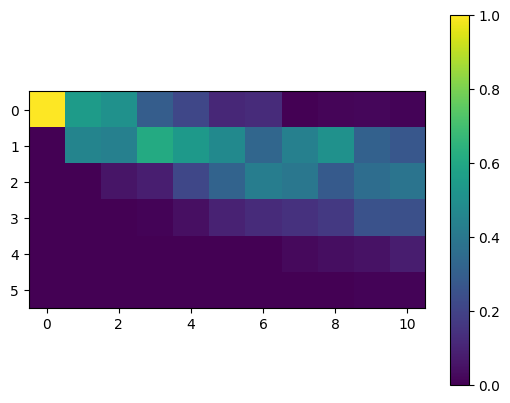

In [ ]:
mat = eff_matrix_peak.aggregate()
mat = mat / mat.sum(axis=0)
plt.imshow(mat)
plt.colorbar()

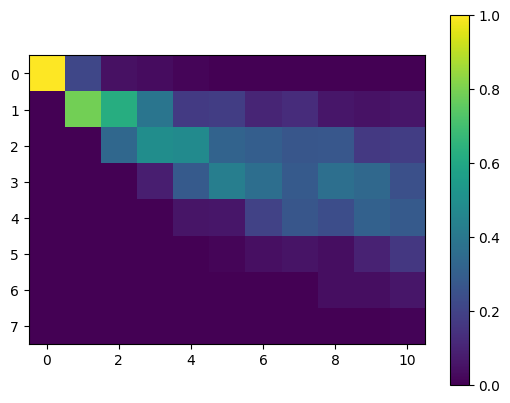

In [ ]:
mat = eff_matrix_sep.aggregate()
mat = mat / mat.sum(axis=0)
plt.imshow(mat)
plt.colorbar()

## Reconstruction metrics histograms

Comparing reconstruction metrics of images on `r`-band.

In [ ]:
from btk.metrics.reconstruction import MSE, PSNR, StructSim
from btk.match import PixelHungarianMatcher
from btk.deblend import SepSingleBand, Scarlet


metrics_sep = {'mse': MSE(batch_size), 
               'psnr': PSNR(batch_size), 
               'ssim': StructSim(batch_size)
               }

metrics_scarlet = {'mse': MSE(batch_size),
                   'psnr': PSNR(batch_size),
                   'ssim': StructSim(batch_size)
                   }

thresh = 5.0

# use psf size as minimum distance between peaks (in pixels).
min_distance = int(get_psf_size(survey))
sep = SepSingleBand(max_n_sources=max_n_sources, thresh=thresh, use_band=2)
scarlet = Scarlet(max_n_sources)
matcher = PixelHungarianMatcher(min_distance)


In [ ]:
import multiprocessing as mp

for ii in tqdm(range(10)):
    blend_batch = next(draw_generator)
    sep_batch = sep(blend_batch)
    scarlet_batch = scarlet(blend_batch, 
                            reference_catalogs=sep_batch.catalog_list, 
                            njobs=mp.cpu_count())
    matching_sep = matcher(blend_batch.catalog_list, sep_batch.catalog_list)
    matching_scarlet = matcher(blend_batch.catalog_list, scarlet_batch.catalog_list) 

    true_iso_images = blend_batch.isolated_images[:, :, 2] # pick 'r' band
    iso_images_sep = sep_batch.deblended_images[:, :, 0] # pick the single band corresponding to 'r' band
    iso_images_scarlet = scarlet_batch.deblended_images[:, :, 2] # pick 'r' band

    iso_images1 = matching_sep.match_true_arrays(true_iso_images)
    iso_images2 = matching_scarlet.match_true_arrays(true_iso_images)
    iso_images_sep = matching_sep.match_pred_arrays(iso_images_sep)
    iso_images_scarlet = matching_scarlet.match_pred_arrays(iso_images_scarlet)

    for metric in metrics_sep.values():
        metric(iso_images1, iso_images_sep)
    
    for metric in metrics_scarlet.values():
        metric(iso_images2, iso_images_scarlet)

100%|██████████| 10/10 [11:20<00:00, 68.06s/it]


In [ ]:
# join data from all batches into single array

# sep 
all_sep = {'mse': np.array([]), 'psnr': np.array([]), 'ssim': np.array([])} 
for metric_name, metric in metrics_sep.items():
    for mvalues in metric.all_data:
        all_sep[metric_name] = np.concatenate([all_sep[metric_name], mvalues[metric_name]])

# scarlet
all_scarlet = {'mse': np.array([]), 'psnr': np.array([]), 'ssim': np.array([])}
for metric_name, metric in metrics_scarlet.items():
    for mvalues in metric.all_data:
        all_scarlet[metric_name] = np.concatenate([all_scarlet[metric_name], mvalues[metric_name]])

In [ ]:
np.mean(all_scarlet['mse']), np.mean(all_sep['mse'])

(58.148150422303, 99.76017439863168)

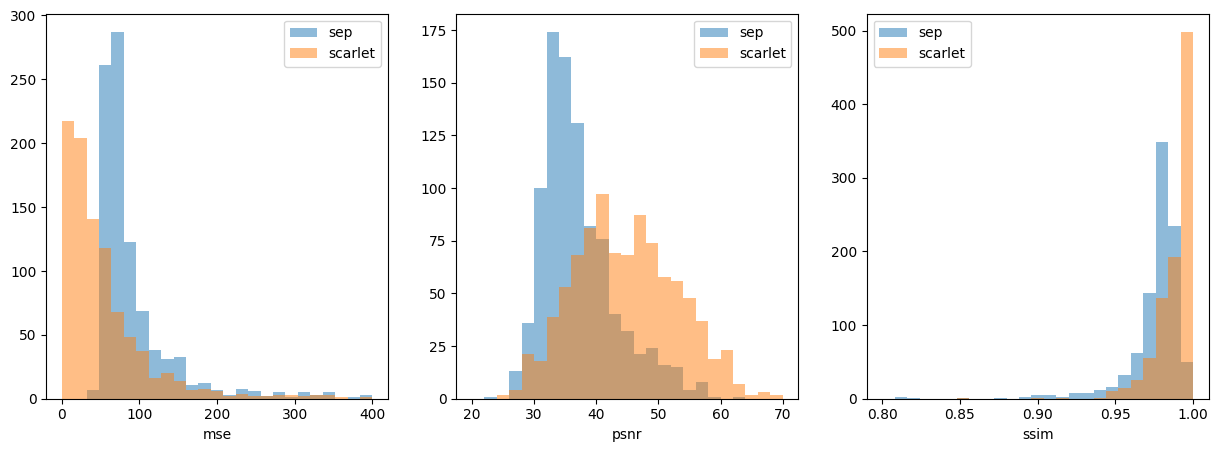

In [ ]:
# plot histograms of each metric for both deblenders 
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ranges = [(0, 400), (20, 70), (0.8, 1.0)]
for ii, metric_name in enumerate(['mse', 'psnr', 'ssim']):
    ax = axes[ii]
    _, bins, _ = ax.hist(all_sep[metric_name], bins=25, alpha=0.5, label='sep', color='C0', histtype='stepfilled',  range=ranges[ii])
    ax.hist(all_scarlet[metric_name], bins=bins, alpha=0.5, label='scarlet', color='C1', histtype='stepfilled',  range=ranges[ii])
    ax.set_xlabel(metric_name)
    ax.legend()

## Precision and Recall curves

In [ ]:
max_n_sources

3

In [ ]:
from btk.deblend import SepSingleBand, PeakLocalMax

# use psf size as minimum distance between peaks (in pixels).
min_distance = int(get_psf_size(survey)) # needs to be an integer

# setup both deblenders
peak_finder = PeakLocalMax(max_n_sources=max_n_sources+3, 
                           threshold_scale=5, 
                           min_distance=min_distance, 
                           use_band=2 # r-band
                           )

sep = SepSingleBand(max_n_sources=max_n_sources+1, thresh=1.5, min_area=3, use_band=2)


In [ ]:
from btk.match import PixelHungarianMatcher

# matcher
matcher = PixelHungarianMatcher(pixel_max_sep=min_distance
                                )

In [ ]:
np.linspace(0, 100, 21)

array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
        55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.])

In [ ]:
from galcheat.utilities import mean_sky_level

# we will continue using 'r' band
sky_level = mean_sky_level(survey, survey.get_filter('r')).to_value('electron') # gain = 1

In [ ]:
from btk.metrics.detection import Recall
from btk.measure import get_snr


snr_bins = np.linspace(0, 100, 21)
recalls_peaks = [Recall(batch_size) for _ in range(1, len(snr_bins))]
recalls_sep = [Recall(batch_size) for _ in range(1, len(snr_bins))]

for _ in tqdm(range(10)):
    blend_batch = next(draw_generator)
    iso_images = blend_batch.isolated_images[:, :, 2] # pick 'r' band
    snr_r = get_snr(iso_images, sky_level)

    peak_batch = peak_finder(blend_batch)
    sep_batch = sep(blend_batch)
    matching_peak = matcher(blend_batch.catalog_list, peak_batch.catalog_list)
    matching_sep = matcher(blend_batch.catalog_list, sep_batch.catalog_list)

    for jj in range(1, len(snr_bins)):
        min_snr, max_snr = snr_bins[jj-1], snr_bins[jj]
        mask = snr_r > min_snr
        matching_peak_new = matching_peak.filter_by_true(mask)
        matching_sep_new = matching_sep.filter_by_true(mask)
        recalls_peaks[jj-1](matching_peak_new)
        recalls_sep[jj-1](matching_sep_new)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:37<00:00,  3.73s/it]


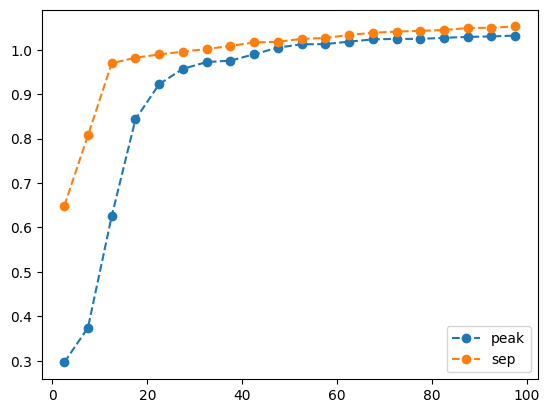

In [ ]:
mean_recalls_peaks = np.array([recall.aggregate() for recall in recalls_peaks])
mean_recalls_sep = np.array([recall.aggregate() for recall in  recalls_sep])

median_bins = (snr_bins[1:] + snr_bins[:-1]) / 2

plt.plot(median_bins, mean_recalls_peaks, '--o', label='peak', color='C0')
plt.plot(median_bins, mean_recalls_sep, '--o', label='sep', color='C1')

plt.legend()

# Sandbox

## Check isin

In [ ]:
a = np.array([0, 10, 11, 21, 5])
mask = a > 10
matches = np.array([1, 2, 3])
indices = np.where(~mask)[0]
indices

array([0, 1, 4])

In [ ]:
x = np.argwhere(np.isin(matches, np.where(~mask)[0]).ravel())

In [ ]:
np.delete(matches, x)

array([2, 3])